In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils

from matplotlib.lines import Line2D
import matplotlib.patches as patches

from pipeline.python.classifications import decode_utils as dutils

In [2]:
%matplotlib notebook

In [3]:
# Set colors
visual_areas, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


In [4]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = '/n/coxfs01/2p-data'

#### Responsive params
responsive_test = 'nstds' # 'nstds' #'ROC' #None
nstd_thr=10
responsive_thr = nstd_thr if responsive_test=='nstds' else 0.05 #0.05 #None
n_stds = None if responsive_test=='ROC' else 2.5 #None

response_type = 'dff'
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 
print(response_str)

#### Experiment to decode
experiment = 'blobs'
stim_filterby = 'first'
has_gratings = False
if experiment=='blobs':
    stimstr = 'hasgratings' if has_gratings else 'blobsonly'
else:
    stimstr = 'gratingsonly'
filter_str = 'filter_%s_%s' % (stim_filterby, stimstr)
print(filter_str)

dff_nstds-thr-10.00
filter_first_blobsonly


# Set ouptut dir

In [5]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

decoding_dir = os.path.join(aggregate_dir, 'decoding')
print(decoding_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding


In [6]:
os.listdir(decoding_dir)

['linear-separability',
 'match_RF_overlap',
 'by_ncells',
 'train-1_test-1',
 'train-subset',
 'train-anchors',
 'single_cells',
 'by_fov',
 'ridge-regr_20190522-JC084_dff_ROC-thr-0.05_.svg',
 'split_pupil']

In [8]:
from pipeline.python.classifications import decode_by_ncells as dc

In [81]:
reload(dc)

<module 'pipeline.python.classifications.decode_by_ncells' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_by_ncells.py'>

# Individual FOVs

In [72]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)

In [82]:
split_pupil=False
C_value=None
trial_epoch='plushalf'
overlap_thr=None

animalid='JC070'
session = '20190316'
fov='FOV1_zoom2p0x'
visual_area = 'Li'
analysis_type = 'split_pupil' if split_pupil else 'by_fov'
#results_prefix = analysis_type

# Get result ID
results_id = dc.create_results_id(prefix=analysis_type, visual_area=visual_area,
                                  C_value=C_value, overlap_thr=overlap_thr, 
                                  trial_epoch=trial_epoch,
                                  response_type=response_type, 
                                  responsive_test=responsive_test)

# Load FOV results
iterd = dc.load_decode_within_fov(animalid, session, fov, 
                                  results_id=results_id, traceid=traceid)

print(results_id, iterd.shape)

('by_fov_Li_tuneC__dff-nstds_no-rfs__plushalf', (200, 15))


In [84]:
iterd.head()
iterd.groupby(['condition']).mean().reset_index()
#iterd.groupby(['arousal']).mean().reset_index()

,condition,C,fit_time,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,score_time,test_score,train_score,n_cells,n_trials,iteration
0,data,2.6083,0.057331,0.026365,0.026087,0.038037,0.595000,0.001279,0.600804,0.813341,84.0,300.0,49.5
1,shuffled,2.6083,0.156536,0.011177,0.003867,0.016124,0.490833,0.001535,0.502213,0.766602,84.0,300.0,49.5


In [383]:
# bds = glob.glob(os.path.join(rootdir, 'JC*', '2019*', '*%s' % fov_type, 'combined_blobs*', 
#                             'traces', '%s*' % traceid, 'decoding', 'fov_results*[*.pkl'))


In [210]:
reload(dc)

<module 'pipeline.python.classifications.decode_by_ncells' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_by_ncells.py'>

# Get aggregate data

In [225]:
C_value=None

trial_epoch='stimulus'
analysis_type='by_fov'
# -------------------------------------------------------------------------------------

C_str = 'tuneC' if C_value is None else 'C%.2f' % float(C_value)
overlap_str = 'no-rfs' if overlap_thr is None else 'RF%.2f' % float(overlap_thr)
data_id = '%s__%s-%s_%s_%s_%s' \
                % (analysis_type, response_type, responsive_test, overlap_str,
                                trial_epoch, C_str)

df = dc.do_decode_within_fov(analysis_type=analysis_type, experiment=experiment, 
                            responsive_test=responsive_test, responsive_thr=responsive_thr,
                            response_type=response_type, traceid=traceid, 
                            C_value=C_value, overlap_thr=overlap_thr, trial_epoch=trial_epoch)

df['animalid'] = [d.split('_')[1] for d in df['datakey']]
df['session'] = [d.split('_')[0] for d in df['datakey']]
df['fovnum'] = [int(d.split('_')[2][3:]) for d in df['datakey']]


AGGREGATE: by_fov___dff-nstds_no-rfs__stimulus__tuneC
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
... renaming
No results for 41 dsets:
SAVING.....
-- results: /n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/by_fov___dff-nstds_no-rfs__stimulus__tuneC.pkl
-- params: /n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/by_fov___dff-nstds_no-rfs__stimulus__tuneC_params.json
DONE!


In [226]:
data_id

'by_fov__dff-nstds_no-rfs_stimulus_tuneC'

In [227]:
df.groupby(['visual_area', 'condition']).mean()

C  fit_time  heldout_MI  heldout_aMI  \
visual_area condition                                               
Li          data       4.39147  0.065551    0.022045     0.019764   
            shuffled   4.39147  0.195534    0.010527     0.003063   

                       heldout_log2MI  heldout_test_score  iteration  n_cells  \
visual_area condition                                                           
Li          data             0.031804            0.575500       49.5     84.0   
            shuffled         0.015188            0.487167       49.5     84.0   

                       n_trials  score_time  test_score  train_score  fovnum  
visual_area condition                                                         
Li          data          300.0     0.00123    0.573784     0.810209     1.0  
            shuffled      300.0     0.00144    0.503831     0.764771     1.0

In [214]:
subdir = data_id.split('__')[-1]

dst_dir = os.path.join(aggregate_dir, 'decoding', analysis_type, subdir)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/dff-nstds_no-rfs_plushalf_tuneC


In [215]:
if 'pupil' in analysis_type:
    diffs=[]
    scores=[]
    for (visual_area, datakey), g in df.groupby(['visual_area', 'datakey']):
        n_low = int(g[g['arousal']=='low']['n_trials'].values)
        n_high = int(g[g['arousal']=='high']['n_trials'].values)
        if n_low!=n_high:
            print('[%s] %s, low=%i, high=%i' % (visual_area, datakey, n_low, n_high))
            diffs.append(n_high - n_low)
            score_high = float(g[g['arousal']=='high'][metric].values)
            score_low = float(g[g['arousal']=='low'][metric].values)
            scores.append(score_high-score_low)     
            
    diffs=np.array(diffs)
    scores=np.array(scores)
    diff_ixs = np.argsort(diffs)

    f, ax = pl.subplots(figsize=(4,4))
    ax.scatter(diffs, scores)
    ax.set_xlim([-16, 16])
    f.text(0, 0.9, "Difference in trial # vs. score difference (low v high)")
    pear_r, pear_p = spstats.pearsonr(diffs, scores)
    ax.set_title('pearson r=%.2f (p=%.2f)' %(pear_r, pear_p), loc='left', fontsize=12)
    pl.subplots_adjust(top=0.7, bottom=0.2, left=0.2)

    ax.set_xlabel('n trials diff')
    ax.set_ylabel('score diff')
    
    figname = 'ntrials_v_score_diffs__%s' % C_str
    putils.label_figure(f, data_id)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    

## N cells v accuracy

<IPython.core.display.Javascript object>


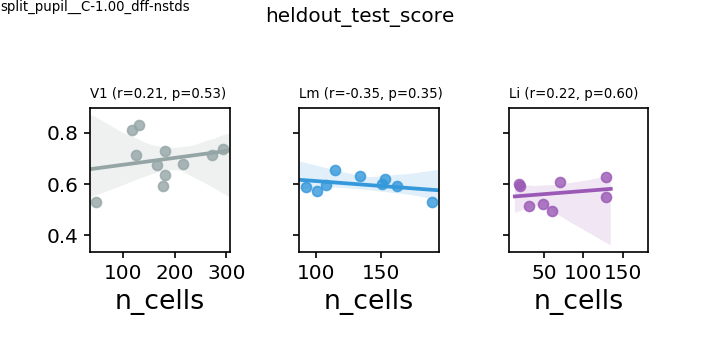

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/split_pupil', 'corr_ncells_heldout_test_score__C-1.00')


In [388]:
metric='heldout_test_score'

if 'pupil' in analysis_type:
    xdf = df[df['arousal']=='all']
else:
    xdf = df.copy()
    
f, axn = pl.subplots(1,3, dpi=dpi, figsize=(6,3), sharex=False, sharey=True)
f.patch.set_alpha(1)


for ai, (visual_area, vdf) in enumerate(xdf.groupby(['visual_area'])):
    ax=axn[2-ai]
    sns.regplot(x='n_cells', y=metric, data=vdf, ax=ax)
    pear_r, pear_p = spstats.pearsonr(vdf['n_cells'].values, vdf[metric].values)
    ax.set_title('%s (r=%.2f, p=%.2f)' % (visual_area, pear_r, pear_p), loc='left', fontsize=8)
    ax.set_ylabel('')
    
f.suptitle(metric)
putils.label_figure(f, data_id)
pl.subplots_adjust(wspace=0.5, top=0.7, bottom=0.3)

figname = 'corr_ncells_%s__%s' % (metric, C_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

# Average classifier accuracy

In [216]:
min_ncells=30

bad_training = df[df['test_score']<0.25]['datakey'].unique()
few_cells = df[df['n_cells']<min_ncells]['datakey'].unique()

excluded = np.union1d(bad_training, few_cells)

plotdf = df[~df['datakey'].isin(excluded)]
plotdf.shape, excluded

((6600, 18), array(['20190319_JC067_fov1', '20190320_JC067_fov1',
        '20190321_JC070_fov1', '20190422_JC076_fov1',
        '20190617_JC099_fov1', '20191111_JC120_fov1'], dtype=object))

<IPython.core.display.Javascript object>


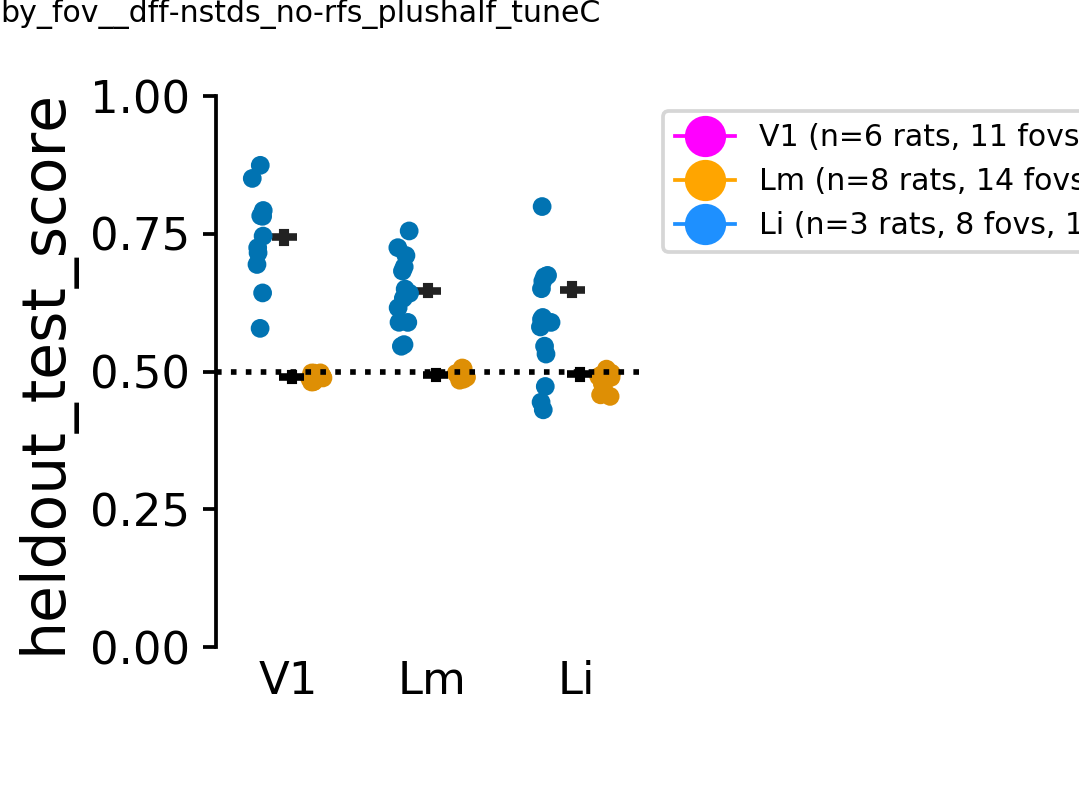

In [217]:
f, ax = pl.subplots(dpi=dpi, figsize=(4,3))
f.patch.set_alpha(1)

if 'pupil' in analysis_type:
    xdf = plotdf[plotdf['arousal']=='all']
else:
    xdf = plotdf.copy()

meandf = xdf.groupby(['visual_area', 'datakey', 'condition']).mean().reset_index()

sns.pointplot(x='visual_area', y=metric, data=xdf, ax=ax, 
              order=visual_areas, hue='condition', 
             color='k', markers='_', scale=1, join=False, dodge=True) #facecolor='none', lw=2)

sns.stripplot(x='visual_area', y=metric, data=meandfs, ax=ax, 
              hue='condition',palette='colorblind', 
              order=visual_areas, zorder=1, s=5, dodge=True) #. palette=area_colors, 

ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')


# statsresults, ax = aggr.plot_mannwhitney(meandf[meandf['condition']=='data'], metric=metric, 
#                                          multi_comp_test=multi_comp_test, ax=ax)

leg = aggr.get_counts_for_legend(meandf, area_colors=area_colors, marker='o')
ax.legend(handles=leg, bbox_to_anchor=(1., 1), fontsize=8)

if metric=='heldout_test_score':
    ax.set_yticks(np.linspace(0, 1, 5))
    sns.despine(ax=ax, trim=True)
    ax.axhline(y=0.5, ls=':', c='k')
sns.despine(bottom=True)
 
putils.label_figure(f, data_id)
pl.subplots_adjust(left=0.2, bottom=0.2, right=0.6)


<IPython.core.display.Javascript object>


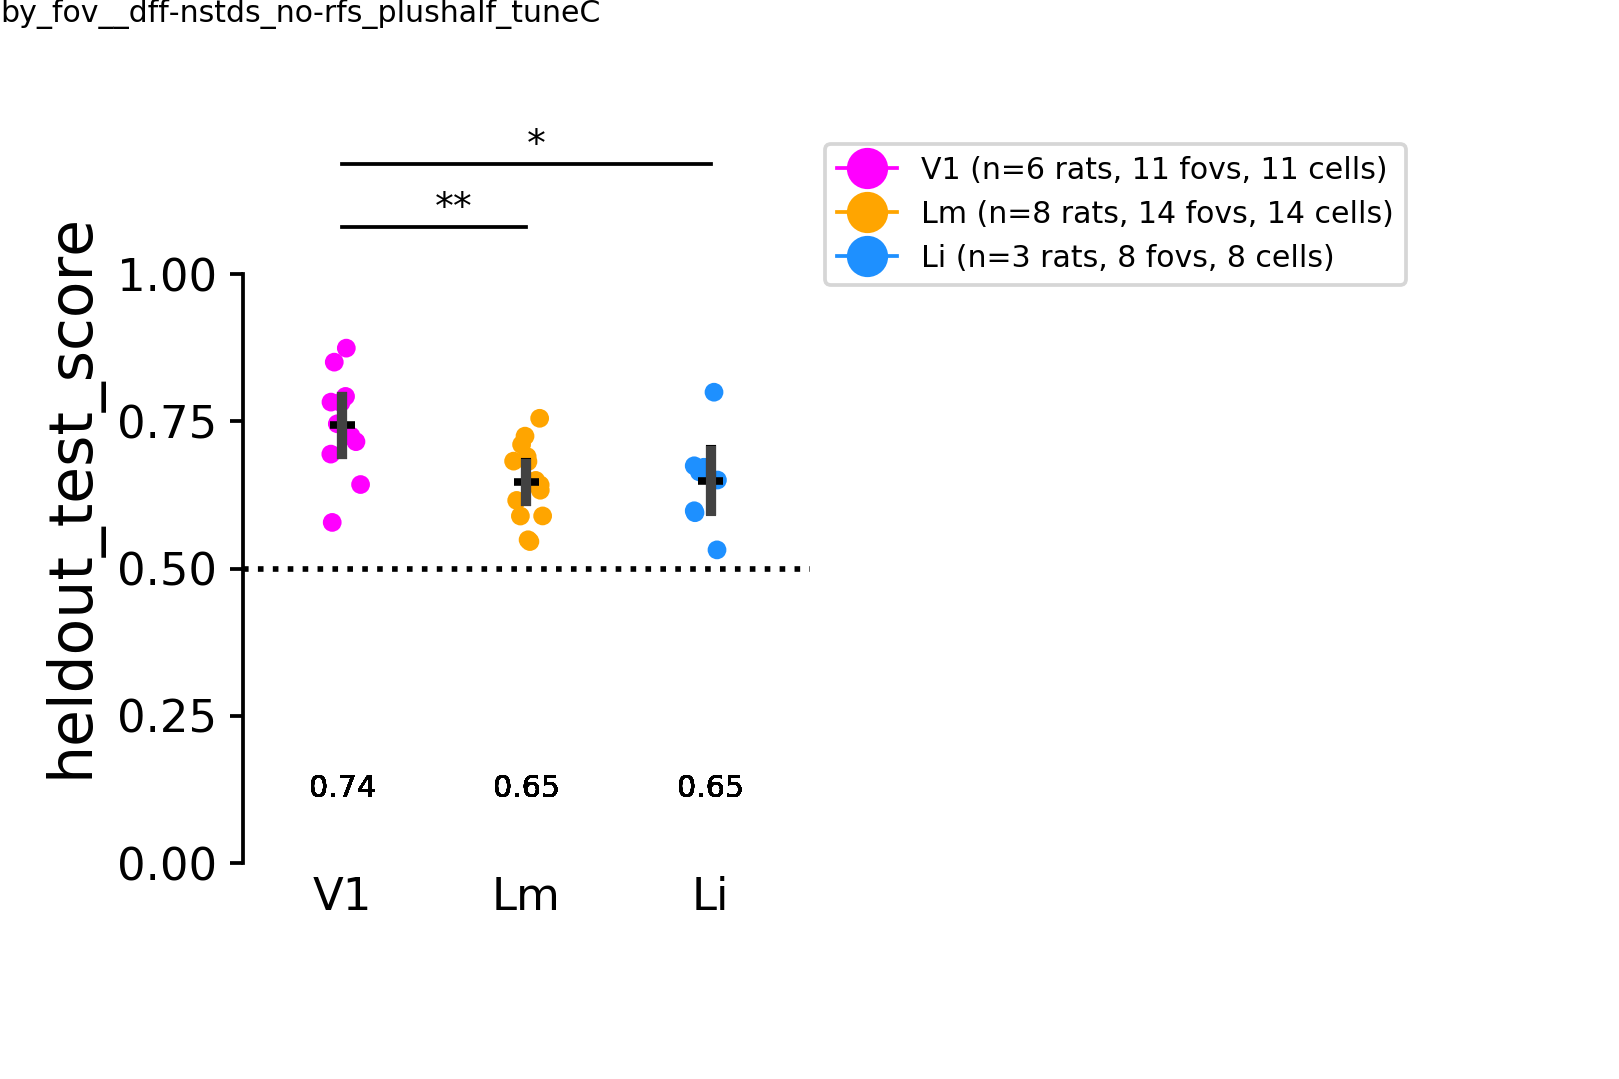

********* [heldout_test_score] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.009 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.032 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.459 (fdr_bh), reject H0=False
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/dff-nstds_no-rfs_plushalf_tuneC', 'overall_heldout_test_score__tuneC')


In [224]:
metric = 'heldout_test_score'
#metric='heldout_log2MI'
multi_comp_test='fdr_bh'

f, ax = pl.subplots(dpi=dpi, figsize=(6,4))
f.patch.set_alpha(1)

if 'pupil' in analysis_type:
    xdf = plotdf[plotdf['arousal']=='all']
else:
    xdf = plotdf.groupby(['visual_area', 'datakey', 'condition']).mean().reset_index()

meandf = xdf[xdf['condition']=='data'].copy()

sns.stripplot(x='visual_area', y=metric, data=meandf, ax=ax,
             palette=area_colors, order=visual_areas, zorder=1, s=5)
sns.pointplot(x='visual_area', y=metric, data=meandf, ax=ax, order=visual_areas,
              markers='_', color='k', join=False, zorder=0)
             #edgecolor=('k', 'k', 'k'), facecolor='none', lw=2)
sns.barplot(x='visual_area', y=metric, data=meandf, ax=ax,
             color='none', facecolor='none', edgecolor='none', order=visual_areas)

meandf.apply(aggr.annotateBars, ax=ax, axis=1, 
             fontsize=8, fontcolor='k', fmt='%.2f', xytext=(0, 20))

    
#### Stats
statsresults, ax = aggr.plot_mannwhitney(meandf, metric=metric, 
                                         multi_comp_test=multi_comp_test, ax=ax)

#### Legend
leg = aggr.get_counts_for_legend(meandf, area_colors=area_colors, marker='o')
ax.legend(handles=leg, bbox_to_anchor=(1., 1), fontsize=8)

#### Formatting
if metric=='heldout_test_score':
    ax.set_yticks(np.linspace(0, 1, 5))
    sns.despine(ax=ax, trim=True)
    ax.axhline(y=0.5, ls=':', c='k')
    
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
sns.despine(bottom=True)
 
putils.label_figure(f, data_id)
pl.subplots_adjust(left=0.15, bottom=0.2, right=0.5)

#### Save
figname = 'overall_%s__%s' % (metric, C_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [312]:
np.linspace(0, 1, 5)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

# Split by arousal

<IPython.core.display.Javascript object>


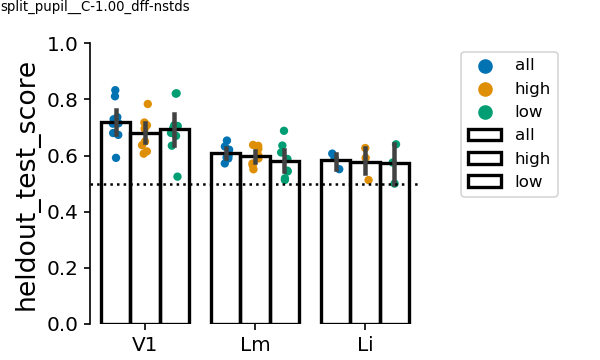

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/split_pupil', 'split_low-v-high_heldout_test_score__C-1.00')


In [391]:
if 'pupil' in analysis_type:
    metric='heldout_test_score'
    f, ax = pl.subplots(dpi=dpi, figsize=(5,3))
    f.patch.set_alpha(1)

    sns.barplot(x='visual_area', y=metric, data=plotdf, ax=ax, hue='arousal',
                order=visual_areas,
                 edgecolor=('k', 'k', 'k'), facecolor='none', lw=2)

    sns.stripplot(x='visual_area', y=metric, data=plotdf, ax=ax, hue='arousal',
                 palette='colorblind', order=visual_areas, zorder=1, s=5, dodge=True)

    sns.despine(bottom=True, ax=ax)
    ax.set_ylim([0, 1])
    ax.axhline(y=0.5, ls=':', c='k')
    ax.legend(bbox_to_anchor=(1.1, 1))

    putils.label_figure(f, data_id)
    pl.subplots_adjust(right=0.7, bottom=0.1, left=0.15)

    figname = 'split_low-v-high_%s__%s' % (metric, C_str)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)

In [219]:
def plot_pairwise_by_axis(plotdf, curr_metric='abs_coef', c1='az', c2='el', 
                          compare_var='cond', fontsize=10, fontcolor='k', fmt='%.2f', xytext=(0, 10),
                          area_colors=None, legend=True):

    fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)
    ax = aggr.pairwise_compare_single_metric(plotdf, curr_metric=curr_metric, ax=ax,
                                                c1=c1, c2=c2, compare_var=compare_var)
    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=fontsize, fontcolor=fontcolor, fmt=fmt, xytext=xytext)
    
    # Set x labels
    aggr.set_split_xlabels(ax, a_label=c1, b_label=c2)

    if legend:
        # Get counts of samples for legend
        legend_elements = aggr.get_counts_for_legend(plotdf, area_colors=area_colors, markersize=10, marker='_')
        ax.legend(handles=legend_elements, bbox_to_anchor=(1.5,1.1), fontsize=8)

    return fig


In [220]:
reload(rfutils)

<module 'pipeline.python.classifications.rf_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/rf_utils.pyc'>

<IPython.core.display.Javascript object>


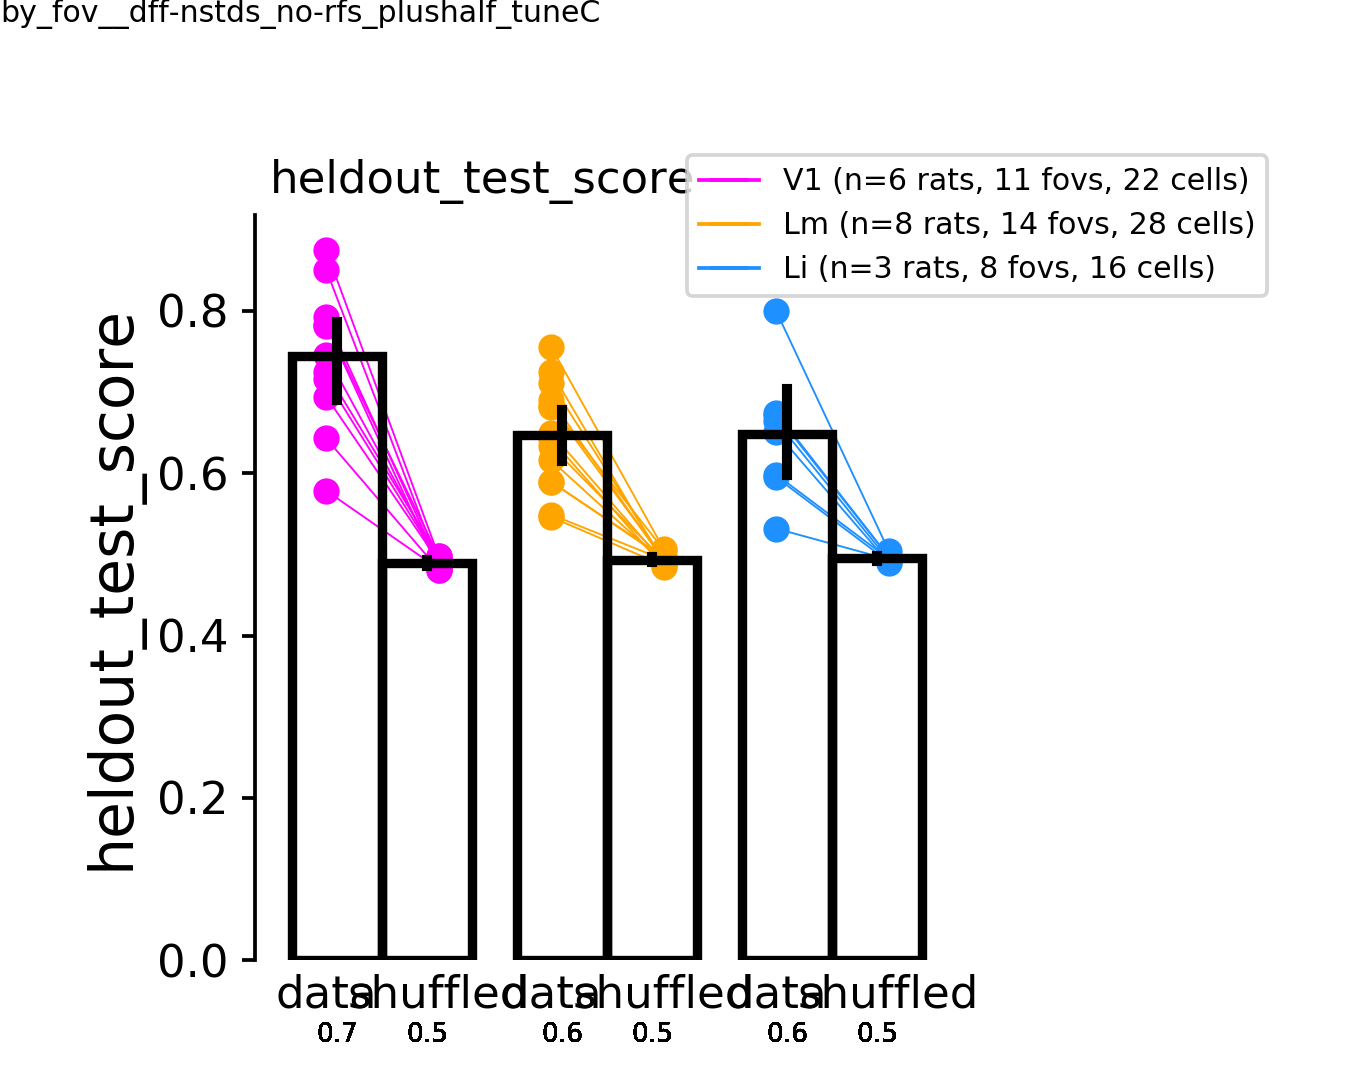

V1: (t-stat:10.06, p=0.00)
Lm: (t-stat:9.24, p=0.00)
Li: (t-stat:5.75, p=0.00)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/dff-nstds_no-rfs_plushalf_tuneC', 'paired_low-v-high_heldout_test_score__tuneC')


In [221]:
metric = 'heldout_test_score'
#metric = 'abs_coef'

if 'pupil' in analysis_type:
    currdf = plotdf[plotdf['arousal'].isin(['low', 'high'])]
    c1='low'
    c2='high'
    compare_var='arousal'
else:
    currdf = xdf.copy()
    c1='data'
    c2='shuffled'
    compare_var='condition'

for metric in ['heldout_test_score']: #, 'heldout_log2MI', 'n_trials']:
    fig = plot_pairwise_by_axis(currdf, curr_metric=metric, 
                                c1=c1, c2=c2, compare_var=compare_var,
                               area_colors=area_colors, fontsize=7, 
                                fontcolor='k', fmt='%.1f', xytext=(0, -20))
    
    pl.subplots_adjust(left=0.2, right=0.7, top=0.8)
    fig.axes[0].set_title(metric, loc='left')
    
    putils.label_figure(fig, data_id)
    
    figname = 'paired_low-v-high_%s__%s' % (metric, C_str)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)

In [164]:
currdf.head()

,visual_area,datakey,condition,C,fit_time,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,score_time,test_score,train_score,n_cells,n_trials,iteration,fovnum,animalid,session
0,Li,20190315_JC070_fov1,data,0.59230,0.007353,0.056369,0.070156,0.081324,0.650500,0.001202,0.648271,0.857830,96.0,300.0,49.5,1.0,JC070,20190315
1,Li,20190315_JC070_fov1,shuffled,0.59230,0.019664,0.013749,0.007640,0.019835,0.489667,0.001378,0.500019,0.779010,96.0,300.0,49.5,1.0,JC070,20190315
2,Li,20190316_JC070_fov1,data,2.60830,0.057331,0.026365,0.026087,0.038037,0.595000,0.001279,0.600804,0.813341,84.0,300.0,49.5,1.0,JC070,20190316
3,Li,20190316_JC070_fov1,shuffled,2.60830,0.156536,0.011177,0.003867,0.016124,0.490833,0.001535,0.502213,0.766602,84.0,300.0,49.5,1.0,JC070,20190316
4,Li,20190602_JC091_fov1,data,0.01252,0.005942,0.201627,0.283002,0.290886,0.799655,0.001729,0.789154,0.920355,137.0,290.0,49.5,1.0,JC091,20190602


<IPython.core.display.Javascript object>


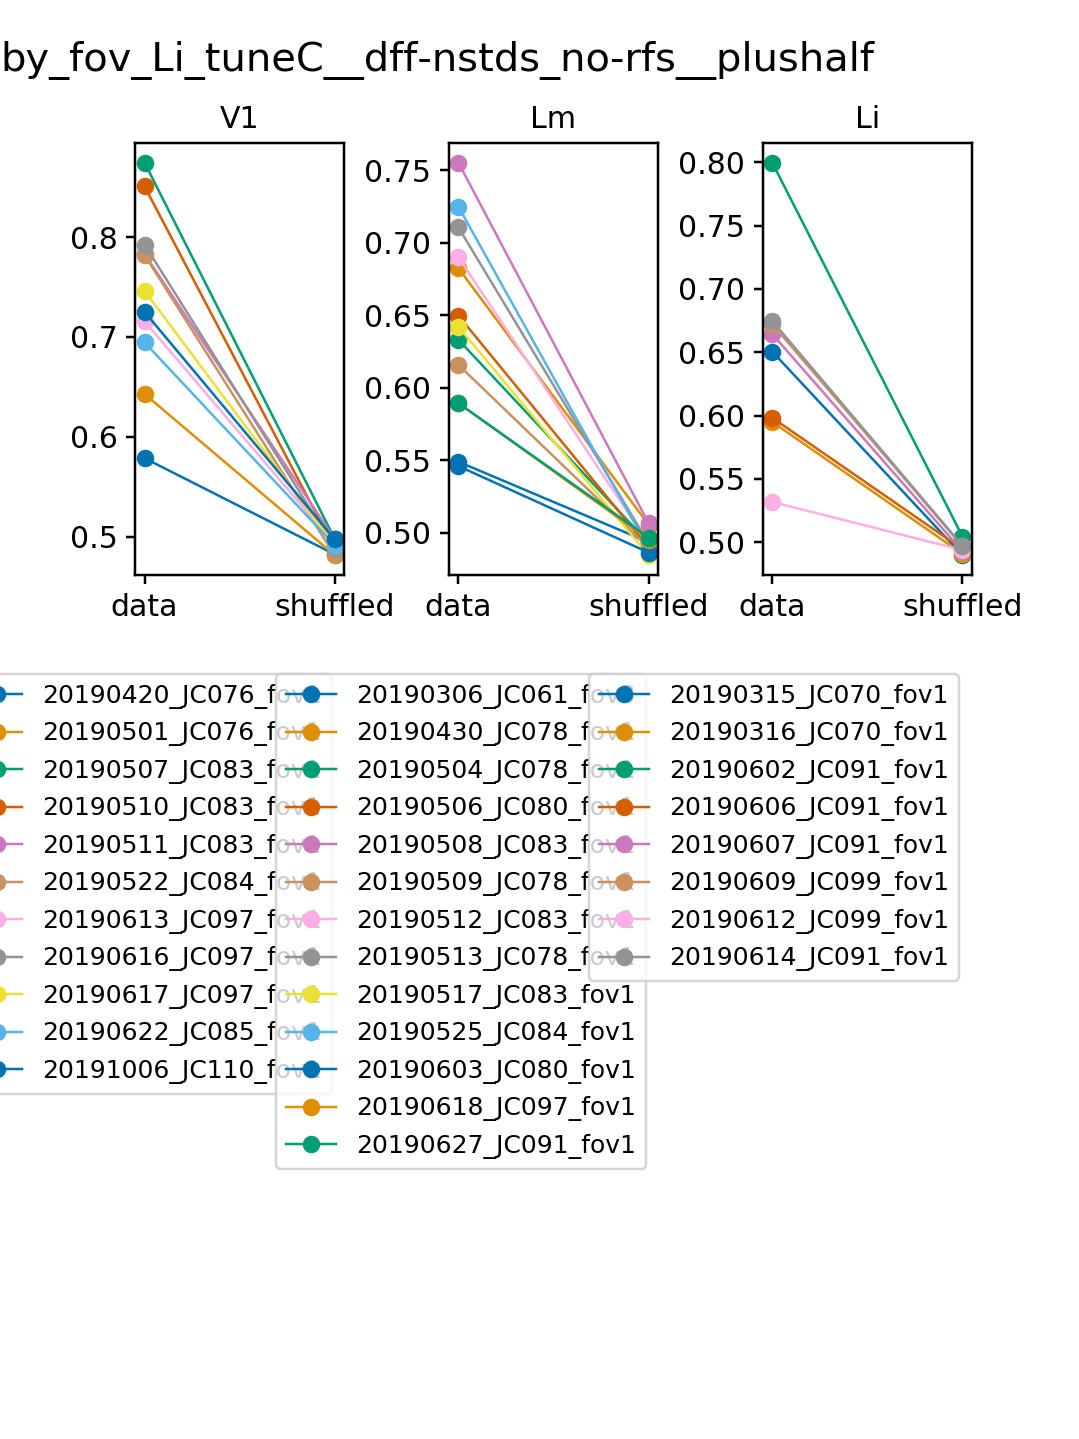

V1: (t-stat:10.06, p=0.00)
Lm: (t-stat:8.52, p=0.00)
Li: (t-stat:5.75, p=0.00)


In [165]:
if 'pupil' in analysis_type:
    currdf = plotdf[plotdf['arousal'].isin(['low', 'high'])]
    c1='low'
    c2='high'
    compare_var='arousal'
else:
    currdf = xdf.copy()
    c1='data'
    c2='shuffled'
    compare_var='condition'
    
    
    
curr_metric='heldout_test_score'
offset = 0.25
marker='o'

f, axn = pl.subplots(1,3, figsize=(6,8))

aix=0
for ai, visual_area in enumerate(visual_areas):
    ax=axn[ai]
    
    df_ = currdf[currdf['visual_area']==visual_area].copy()
    a_vals = df_[df_[compare_var]==c1].sort_values(by='datakey')[curr_metric].values
    b_vals = df_[df_[compare_var]==c2].sort_values(by='datakey')[curr_metric].values

    by_exp = [(a, e) for a, e in zip(a_vals, b_vals)]
    color_list = sns.color_palette('colorblind', n_colors=len(by_exp))
    labels = df_[df_[compare_var]==c1].sort_values(by='datakey')['datakey'].values
    
    for pi, (p, plabel) in enumerate(zip(by_exp, labels)):
        ax.plot([aix-offset, aix+offset], p, marker=marker, color=color_list[pi], 
                alpha=1, lw=1,  zorder=0, markerfacecolor=None, 
                markeredgecolor=color_list[pi], label=plabel)
        
    ax.set_xticks([aix-offset, aix+offset])
    ax.set_xticklabels([c1, c2])
    tstat, pval = spstats.ttest_rel(a_vals, b_vals)
    print("%s: (t-stat:%.2f, p=%.2f)" % (visual_area, tstat, pval))
    aix = aix+1
    ax.set_title(visual_area)
    
    ax.legend(bbox_to_anchor=(1, -0.2))

#     # Plot average
#     sns.barplot([0, 1], curr_metric, data=df_, 
#                 hue=compare_var, hue_order=[c1, c2], #zorder=0,
#                 ax=ax, #order=visual_areas,
#                 errcolor="k", edgecolor=('k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
#     #ax.legend_.remove()

# rfutils.set_split_xlabels(ax, a_label=c1, b_label=c2)

f.text(0, 0.95, '%s' % results_id, fontsize=16)
pl.subplots_adjust(bottom=0.6, wspace=0.5, top=0.9)


# figname = 'paired_low-v-high_color-FOV_%s__%s' % (metric, C_str)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# print(dst_dir, figname)

In [166]:
currdf[(currdf['condition']=='data') & (currdf['visual_area']=='Li') & (currdf[metric]<=0.5)]

,visual_area,datakey,condition,C,fit_time,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,score_time,test_score,train_score,n_cells,n_trials,iteration,fovnum


In [40]:
bds = glob.glob(os.path.join(rootdir, 'JC*', '2019*', '*%s' % fov_type, 'combined_blobs*', 
                            'traces', '%s*' % traceid, 'decoding', 'splitpupil*.pkl'))
bds

['/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_ea0b53_traces001_92d492_traces001_af4cfd_traces001_9188fa_traces001_b44714_traces001_133108/decoding/splitpupil_results_V1_tuneC__dff-nstds.pkl',
 '/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_dea723_traces001_8cef6c_traces001_abf256_traces001_fb7bfa_traces001_452942_traces001_c0afbd/decoding/splitpupil_results_Lm_tuneC__dff-nstds.pkl',
 '/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_573669_traces001_3d2687_traces001_17838a_traces001_452178_traces001_c84a17_traces001_faae98/decoding/splitpupil_results_Li_tuneC__dff-nstds.pkl',
 '/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_2afecb_traces001_8b62a3_traces001_fa925f_traces001_bcbaba_traces001_821fff_traces001_361c93/decoding/splitpupil_results_Li_tuneC__dff-nstds.pkl',
 '/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/combined_b

In [37]:
rfile = bds[1]
with open(rfile, 'rb') as f:
    d = pkl.load(f)
d.groupby(['arousal']).mean()

,C,fit_time,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,n_cells,n_trials,score_time,test_score,train_score
arousal,,,,,,,,,,,
all,0.02386,0.171685,0.170252,0.237016,0.245622,0.776333,294,300,0.032981,0.758129,0.974251
high,0.03430,0.025259,0.084630,0.084727,0.122095,0.664211,294,93,0.009571,0.637845,0.974595
low,0.03484,0.029401,0.080132,0.081467,0.115606,0.676000,294,100,0.008663,0.702166,0.979818


In [36]:
d.groupby(['arousal']).mean()

,C,fit_time,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,n_cells,n_trials,score_time,test_score,train_score
arousal,,,,,,,,,,,
all,0.02962,0.070754,0.193766,0.271013,0.279545,0.792069,136,290,0.021631,0.793375,0.917475
high,0.03142,0.013911,0.145102,0.179215,0.209338,0.731000,136,97,0.005092,0.740175,0.967003
low,0.01180,0.015889,0.119079,0.141496,0.171794,0.722857,136,102,0.006979,0.731188,0.949439


In [19]:
metric='heldout_test_score'
res[metric].mean(), res[metric].std()

(0.7258333333333333, 0.059429338210849815)

# Equal trial counts

In [69]:
trial_epoch = 'stimulus'
MEANS = aggr.load_aggregate_data(experiment, responsive_test=responsive_test, responsive_thr=responsive_thr, 
               response_type=response_type, epoch=trial_epoch)

MEANS = equal_counts_per_condition(MEANS)


...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl
20190512_JC083_fov1: n=31
20190606_JC091_fov1: n=32
20190605_JC090_fov1: n=32
20190602_JC091_fov1: n=29
20190508_JC083_fov1: n=29
20190617_JC097_fov1: n=29
20190430_JC078_fov1: n=29
20191006_JC110_fov1: n=33
20190617_JC099_fov1: n=19
20190513_JC078_fov1: n=29
20190502_JC076_fov1: n=26


In [66]:
len(curr_counts.unique())


3

# Classify A/B, by NCELLS

In [39]:
train_str = 'traintest_by-ncells' 
glob.glob(os.path.join(decoding_dir, 'by_ncells', '%s_iter*.pkl' % (train_str)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells/traintest_by-ncells_iter-500_overlap-0.80_results_20200926.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells/traintest_by-ncells_iter-50_overlap-0.80_results_20200926.pkl']

In [95]:
dst_dir = os.path.join(decoding_dir, 'by_ncells')
os.listdir(dst_dir)

['traintest_by-ncells_iter-500_overlap-0.80_results_20200926.pkl',
 'traintest_by-ncells_iter-500_overlap-0.80_params_20200926.json',
 'traintest_by-ncells_iter-500__heldout_test_scorezoom_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_iter-500__heldout_test_score_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_iter-500__heldout_log2MI_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_iter-500__heldout_log2MIzoom_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_iter-500__heldout_aMI_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_iter-500__heldout_aMIzoom_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_overlap-0.80_decode_heldout_log2MI_20200926.svg',
 'traintest_by-ncells_overlap-0.80_decode_heldout_log2MIzoom_20200926.svg',
 'traintest_by-ncells_overlap-0.80_decode_heldout_test_scorezoom_20200926.svg',
 'traintest_by-ncells_overlap-0.80_d

In [96]:
n_iterations = 500
overlap_thr=0.8
train_str = 'traintest_by-ncells' 
glob.glob(os.path.join(dst_dir, '%s_iter-%i_overlap-%.2f_*.pkl' % (train_str, n_iterations, overlap_thr)))
#glob.glob(os.path.join(dst_dir, '*overlap-%.2f_*.pkl' % (overlap_thr)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells/traintest_by-ncells_iter-500_overlap-0.80_results_20200926.pkl']

In [97]:
results_dfile = glob.glob(os.path.join(dst_dir, 
                                      '%s_iter-%i_overlap-%.2f_*.pkl' % (train_str, n_iterations, overlap_thr)))[0]

# results_dfile = glob.glob(os.path.join(dst_dir, 
#                                        '*overlap-%.2f_*.pkl' % (overlap_thr)))[0]
#results_dfile = os.path.join(dst_dir, 'results_20200924.pkl')
# 'results_overlap-0.80.pkl' 200 cells, incoplete

with open(results_dfile, 'rb') as f:
    results = pkl.load(f)
if isinstance(results, dict):
    print(results.keys())
    results = results['pooled']
    #sdf = resultsdict['sdf']
else:
    results = results
    
results_basename = os.path.splitext(os.path.split(results_dfile)[-1])[0]
params_dfile = '%s.json' % os.path.splitext(results_dfile)[0].replace('results', 'params')
if os.path.exists(params_dfile):
    with open(params_dfile, 'r') as f:
        params = json.load(f)
    print("Train/test params for %s:" % train_str)
    pp.pprint(params)
else:
    print("No params")
print("File basename: %s" % results_basename)

['pooled']
Train/test params for traintest_by-ncells:
{   u'C_value': None,
    u'cv': True,
    u'cv_nfolds': 5,
    u'n_iterations': 500,
    u'overlap_thr': 0.8,
    u'test_split': 0.2}
File basename: traintest_by-ncells_iter-500_overlap-0.80_results_20200926


In [98]:
results.keys()

Index([u'C', u'C_sem', u'C_std', u'fit_time', u'fit_time_sem', u'fit_time_std',
       u'heldout_MI', u'heldout_MI_sem', u'heldout_MI_std', u'heldout_aMI',
       u'heldout_aMI_sem', u'heldout_aMI_std', u'heldout_log2MI',
       u'heldout_log2MI_sem', u'heldout_log2MI_std', u'heldout_test_score',
       u'heldout_test_score_sem', u'heldout_test_score_std', u'n_units',
       u'overlap', u'score_time', u'score_time_sem', u'score_time_std',
       u'test_accuracy', u'test_accuracy_sem', u'test_accuracy_std',
       u'test_precision_macro', u'test_precision_macro_sem',
       u'test_precision_macro_std', u'test_recall_macro',
       u'test_recall_macro_sem', u'test_recall_macro_std', u'train_accuracy',
       u'train_accuracy_sem', u'train_accuracy_std', u'train_precision_macro',
       u'train_precision_macro_sem', u'train_precision_macro_std',
       u'train_recall_macro', u'train_recall_macro_sem',
       u'train_recall_macro_std', u'visual_area'],
      dtype='object')

In [99]:
date_str = results_basename.split('_')[-1]
plot_str = '_test_%s_overlap-%.2f' % (train_str, overlap_thr)
fig_str = '%s_%s' % (response_str, filter_str)
data_id = '%s|%s' % (traceid, fig_str)
print(data_id)
print(plot_str)
print(date_str)

traces001|dff_nstds-thr-10.00_filter_first_blobsonly
_test_traintest_by-ncells_overlap-0.80
20200926


In [100]:
reload(dutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.pyc'>

<IPython.core.display.Javascript object>


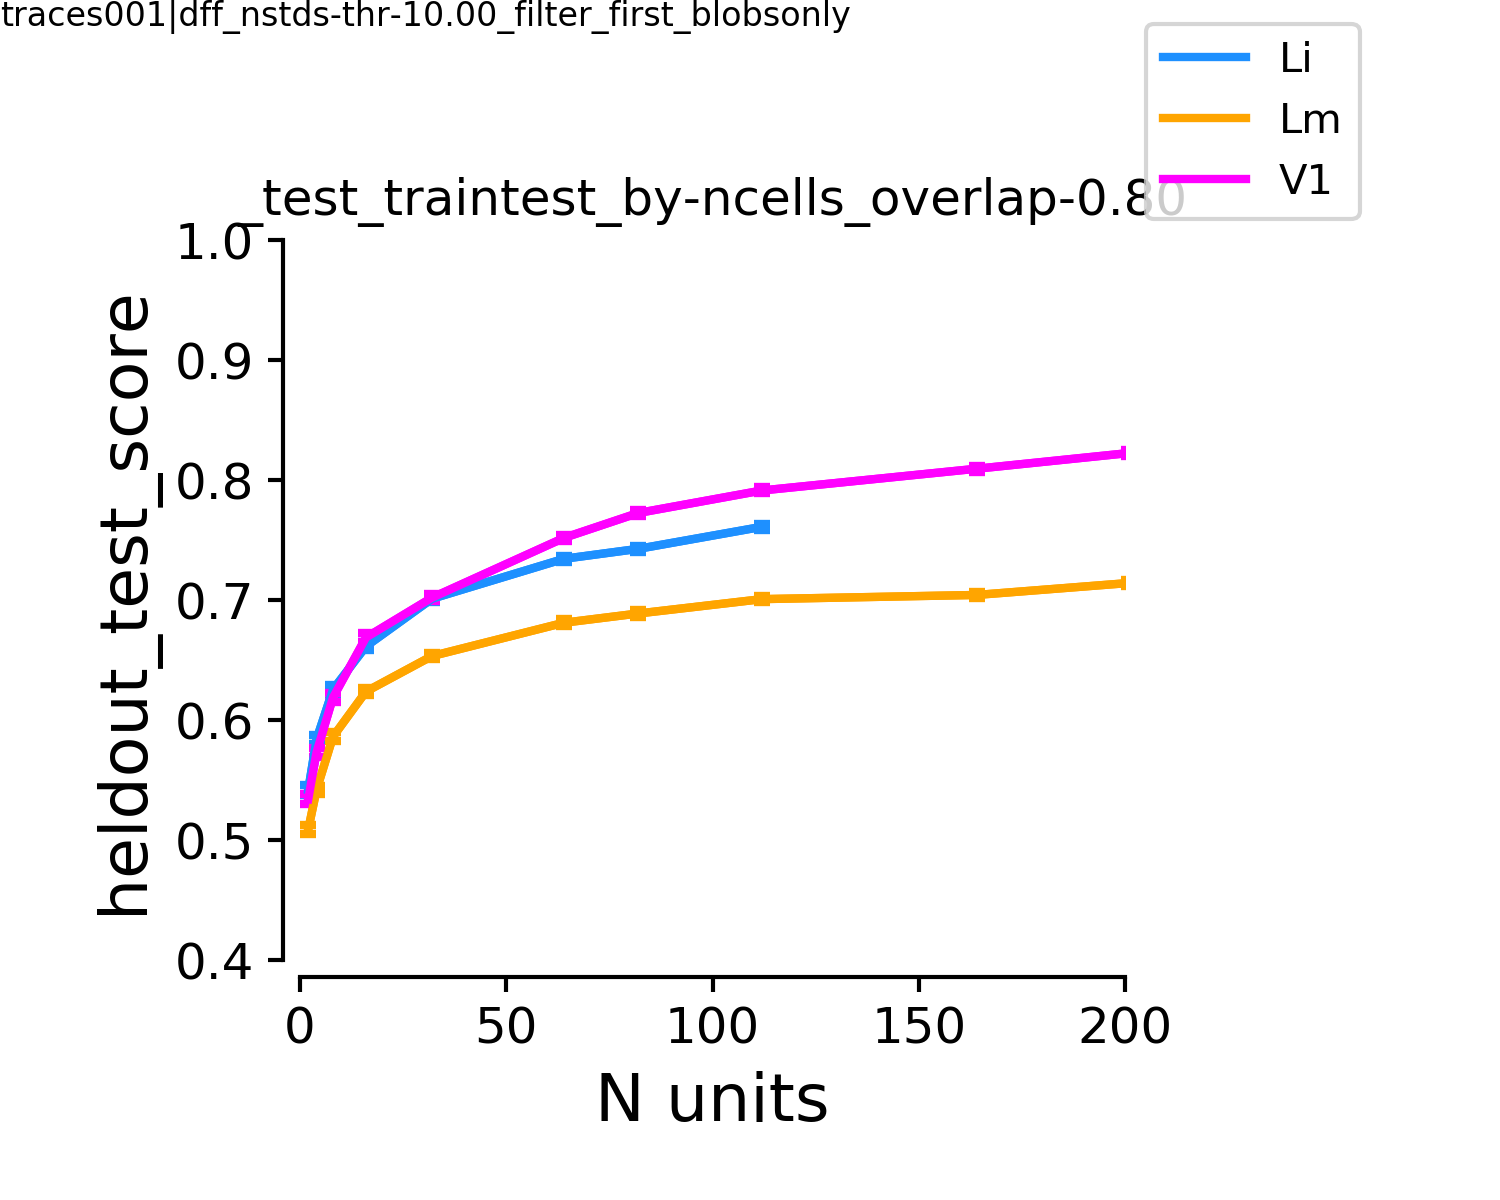

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells', '_test_traintest_by-ncells_overlap-0.80_decode_heldout_test_scorezoom')


<IPython.core.display.Javascript object>


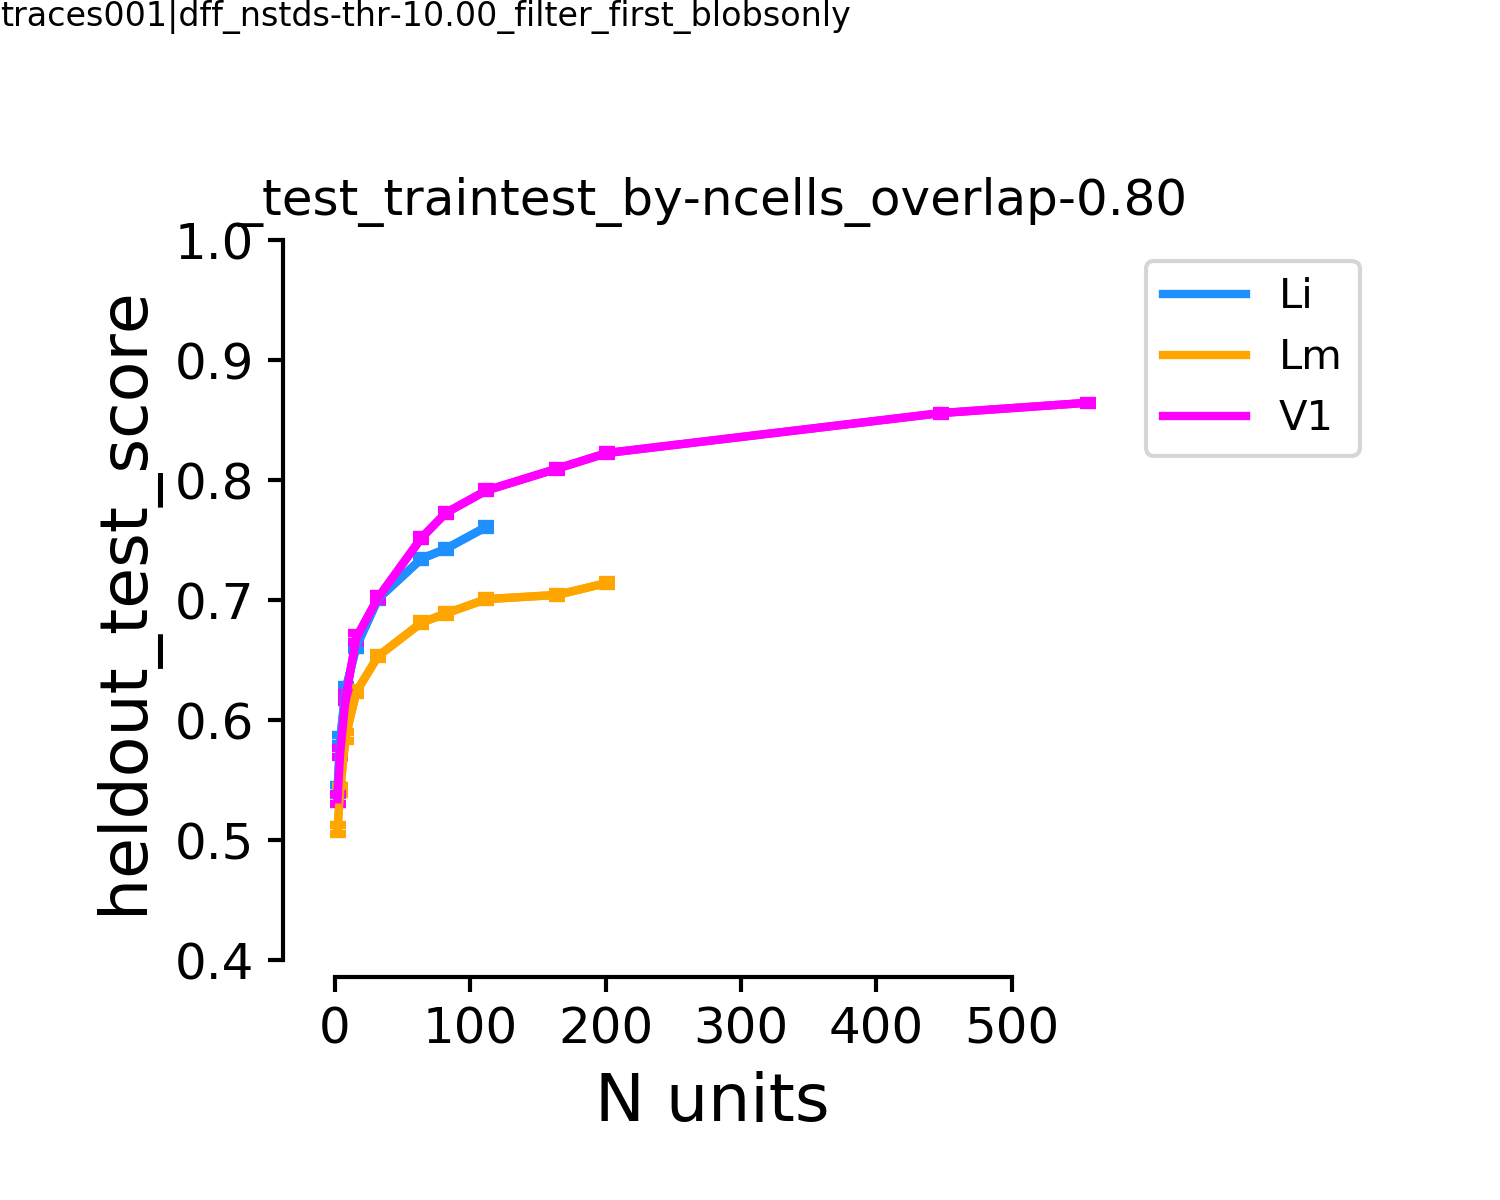

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells', '_test_traintest_by-ncells_overlap-0.80_decode_heldout_test_score')


In [101]:
metric = 'heldout_test_score'
dutils.default_classifier_by_ncells(results, metric=metric, plot_str=plot_str, date_str=date_str,
                                    dst_dir=dst_dir, data_id=data_id, area_colors=area_colors, xlim=200)
                                    

# Test Generalization -- size

In [60]:
n_train_configs=4
n_iterations = 100
sample_ncells=112
train_str = 'train-%i_sample-%i_iter-%i' % (n_train_configs, sample_ncells, n_iterations)  

overlap_thr=0.8
glob.glob(os.path.join(decoding_dir, 'match_RF_overlap', '%s*.pkl' % (train_str)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap/train-4_sample-112_iter-100_results.pkl']

In [65]:
overlap_dir = os.path.join(decoding_dir, 'match_RF_overlap')
results_dfile = glob.glob(os.path.join(overlap_dir, '%s*.pkl' % (train_str)))[0]
with open(results_dfile, 'rb') as f:
    results = pkl.load(f)

results_basename = os.path.splitext(os.path.split(results_dfile)[-1])[0]
print("File basename: %s" % results_basename)

File basename: train-4_sample-112_iter-100_results


In [12]:
animalid = 'JC097'
session = '20190616'
fovnum = 1
exp = util.Objects(animalid, session, 'FOV%i_zoom2p0x' % fovnum, traceid=traceid)
sdf = exp.get_stimuli()


In [67]:
plot_str = '%s_overlap-%.2f' % (train_str, overlap_thr)
fig_str = '%s_%s' % (response_str, filter_str)
data_id = '%s|%s' % (traceid, fig_str)
print(data_id)

traces001|dff_nstds-thr-10.00_filter_first_blobsonly


In [71]:
reload(dutils)

<module 'pipeline.python.classifications.decode_utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/decode_utils.py'>

<IPython.core.display.Javascript object>


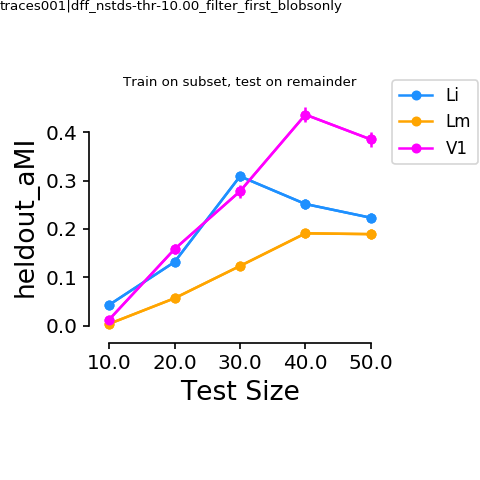

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap', 'train-4_sample-112_iter-100_overlap-0.80_generalize_size')


<IPython.core.display.Javascript object>


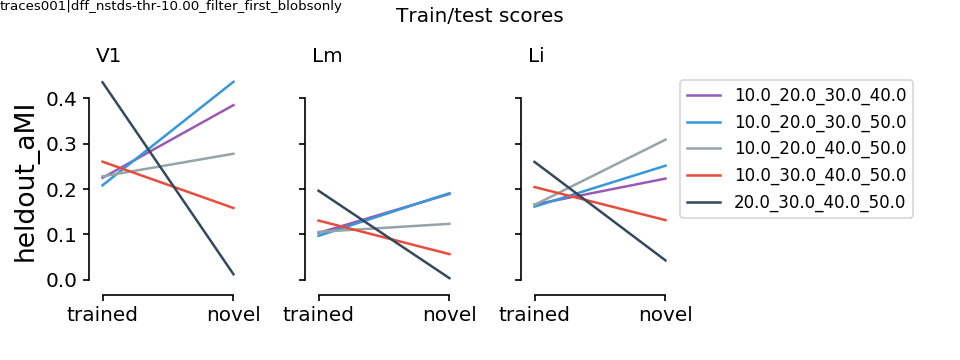

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap', 'train-4_sample-112_iter-100_overlap-0.80_generalize_size__avg-novel-v-trained')


<IPython.core.display.Javascript object>


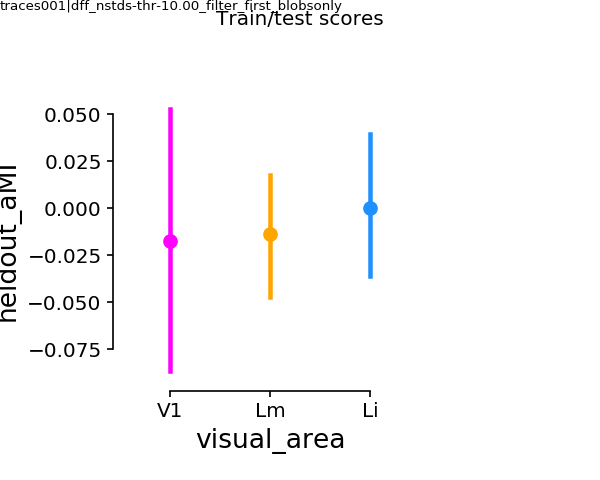

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap', 'train-4_sample-112_iter-100_overlap-0.80_generalize_size__avg-novel-v-trained-difference')


In [73]:
metric = 'heldout_aMI'
dutils.default_train_test_subset(results, sdf, metric=metric, area_colors=area_colors, 
                                 plot_str=plot_str, data_id=data_id, dst_dir=overlap_dir)


In [77]:
results.head()

,C,fit_time,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_transform,train_accuracy,train_precision_macro,train_recall_macro,train_transform,iteration,n_units,visual_area,overlap
0,0.010,0.002216,0.055217,0.065015,0.079662,0.659574,0.002186,0.773052,0.780050,0.773099,10.0_20.0_30.0_40.0,0.878349,0.878713,0.878306,10.0_20.0_30.0_40.0,0,112,Li,0.8
1,0.010,0.002216,0.167874,0.232338,0.242191,0.758621,0.002186,0.773052,0.780050,0.773099,50.0,0.878349,0.878713,0.878306,10.0_20.0_30.0_40.0,0,112,Li,0.8
2,0.001,0.002637,0.134455,0.180996,0.193977,0.744681,0.002641,0.696989,0.728557,0.698246,10.0_20.0_30.0_50.0,0.772837,0.806416,0.773706,10.0_20.0_30.0_50.0,0,112,Li,0.8
3,0.001,0.002637,0.062245,0.077773,0.089801,0.637931,0.002641,0.696989,0.728557,0.698246,40.0,0.772837,0.806416,0.773706,10.0_20.0_30.0_50.0,0,112,Li,0.8
4,0.010,0.002267,0.153134,0.208435,0.220926,0.765957,0.002227,0.675786,0.691301,0.675439,10.0_20.0_40.0_50.0,0.850086,0.851258,0.850153,10.0_20.0_40.0_50.0,0,112,Li,0.8


# Test generalization - 1 size

In [83]:
n_train_configs=1
n_iterations = 100
sample_ncells=112
train_str = 'train-%i_sample-%i_iter-%i' % (n_train_configs, sample_ncells, n_iterations)  

overlap_thr=0.8
glob.glob(os.path.join(decoding_dir, 'train-1_test-1', '%s*.pkl' % (train_str)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1/train-1_sample-112_iter-100_results.pkl']

In [84]:
dst_dir = os.path.join(decoding_dir, 'train-1_test-1')
results_dfile = glob.glob(os.path.join(dst_dir, '%s*.pkl' % (train_str)))[0]
with open(results_dfile, 'rb') as f:
    results = pkl.load(f)

results_basename = os.path.splitext(os.path.split(results_dfile)[-1])[0]
print("File basename: %s" % results_basename)

File basename: train-1_sample-112_iter-100_results


In [85]:
plot_str = '%s_overlap-%.2f' % (train_str, overlap_thr)
fig_str = '%s_%s' % (response_str, filter_str)
data_id = '%s|%s' % (traceid, fig_str)
print(data_id)

traces001|dff_nstds-thr-10.00_filter_first_blobsonly


<IPython.core.display.Javascript object>


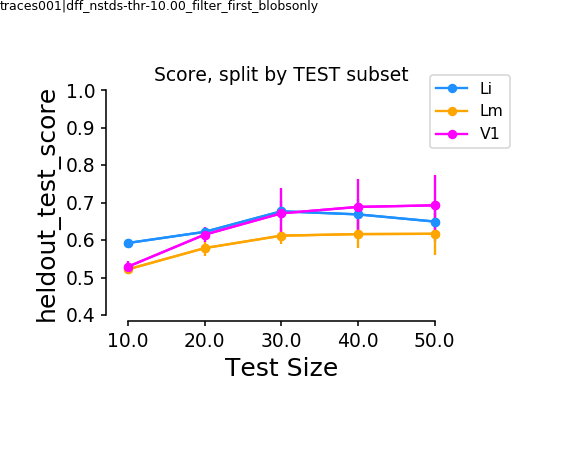

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1', 'train-1_sample-112_iter-100_overlap-0.80_heldout_test_score_by-test-size')


In [468]:
metric = 'heldout_test_score'
testdf = pd.concat([g[g['test_transform']!=train].groupby(['visual_area', 'test_transform']).mean() \
           for (visual_area, train), g in results.groupby(['visual_area', 'train_transform'])]).reset_index()


fig, ax = pl.subplots(figsize=(5,4), dpi=150)
# dutils.plot_scores_by_test_set(results, sdf, metric=metric, area_colors=area_colors, ax=ax, plot_sem=True)

sizes = [str(s) for s in sdf['size'].unique()]
markersize=5
for visual_area, vdf in testdf.groupby(['visual_area']):
    #for train, traindf in vdf.groupby(['train_transform']):
    mean_vals = vdf.groupby(['test_transform']).mean()[metric]
    sem_vals = vdf.groupby(['test_transform']).sem()[metric]

    ax.plot(np.arange(0, len(sizes)), mean_vals, color=area_colors[visual_area],
               marker='o', markersize=markersize, label=visual_area)
    ax.errorbar(np.arange(0, len(sizes)), mean_vals, yerr=sem_vals, color=area_colors[visual_area],
               marker='o', markersize=markersize, label=None)

    ax.set_xticks(np.arange(0, len(sizes)))
    ax.set_xticklabels(sizes)

ax.set_xlabel('Test Size', fontsize=16)
ax.set_ylabel(metric, fontsize=16)
pl.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.3, wspace=0.3)

ax.legend(bbox_to_anchor=(1.2, 1.1))

if metric=='heldout_test_score':
    ax.set_ylim([0.4, 1])
else:
    ax.set_ylim([0, 0.4])
sns.despine(trim=True,offset=4)

putils.label_figure(fig, data_id)
ax.set_title("Score, split by TEST subset")

figname = '%s_%s_by-test-size' % (plot_str, metric)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


In [385]:
sizes = sdf['size'].unique()

#### Relative score

In [517]:
subtract_novel=True
metric = 'heldout_test_score'

metric_names = [p for p in results.columns if 'heldout' in p or 'C' in p]
mean_results=results.groupby(['visual_area', 'train_transform', 'test_transform']).mean()[metric_names].reset_index()

relative_df = pd.concat([pd.DataFrame({
                          'trained': [float(g[g['test_transform']==train][metric].values) for _ in np.arange(0, len(g)-1)],
                          'novel': g[g['test_transform']!=train][metric],
                          'visual_area': [visual_area for _ in np.arange(0, len(g)-1)], 
                          'train_transform': [train for _ in np.arange(0, len(g)-1)], 
                          'test_transform': g[g['test_transform']!=train]['test_transform']}) \
             for (visual_area,train), g in mean_results.groupby(['visual_area', 'train_transform'])])

if subtract_novel:
    relative_df['relative_%s' % metric] = (relative_df['trained'] - relative_df['novel']) #/ relative_df['trained']
else:
    relative_df['relative_%s' % metric] = (relative_df['novel'] - relative_df['trained']) #/ relative_df['trained']

relative_str='subtract-novel' if subtract_novel else 'subtract-trained'

<IPython.core.display.Javascript object>


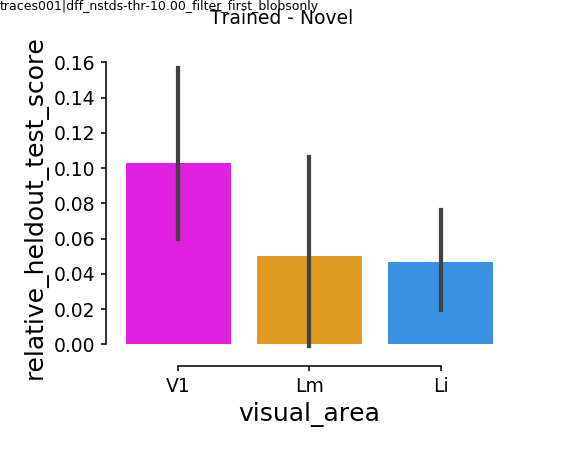

********* [relative_heldout_test_score] Mann-Whitney U test(mc=holm) **********
[('V1', 'Lm')] p=0.115 (holm), reject H0=False
[('V1', 'Li')] p=0.115 (holm), reject H0=False
[('Lm', 'Li')] p=0.299 (holm), reject H0=False
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1', 'train-1_sample-112_iter-100_overlap-0.80_avg-novel-v-trained_relative_heldout_test_score_subtract-novel')


In [518]:
fig, ax = pl.subplots(1, dpi=dpi, figsize=(5,4), sharex=True, sharey=True)
sns.barplot(x='visual_area', y='relative_%s' % metric, data=relative_df, ax=ax,
           order=visual_areas, palette=area_colors)
#sns.stripplot(x='visual_area', y='relative_%s' % metric, data=relative_df, ax=ax,
#            hue='test_transform', palette='colorblind', order=visual_areas, dodge=True)
statresults, ax = aggr.plot_mannwhitney(relative_df, metric='relative_%s' % metric, multi_comp_test='holm', ax=ax)
sns.despine(trim=True, offset=4)

pl.subplots_adjust(left=0.2, right=0.9, bottom=0.2)

putils.label_figure(fig, data_id)


if subtract_novel:
    fig.suptitle('Trained - Novel')
else:
    fig.suptitle('Novel - Trained')

figname = '%s_avg-novel-v-trained_relative_%s_%s' % (plot_str, metric, relative_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


<IPython.core.display.Javascript object>


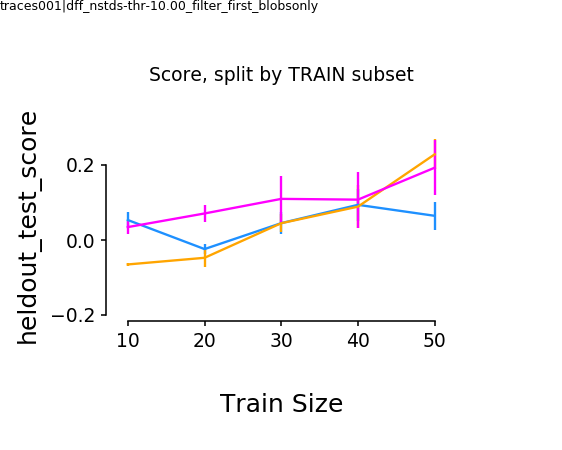

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1', 'train-1_sample-112_iter-100_overlap-0.80_heldout_test_score_by-train-size')


In [465]:
# Plot.

sizes = sdf['size'].unique()

fig, ax = pl.subplots(1, dpi=dpi, figsize=(5,4), sharex=True, sharey=True)

for visual_area, vdf in relative_df.groupby(['visual_area']):
    ai = visual_areas.index(visual_area)
    
    mean_vals = vdf.groupby(['train_transform']).mean()['relative_%s' % metric]
    sem_vals = vdf.groupby(['train_transform']).sem()['relative_%s' % metric]
    xv = sizes
    
    ax.errorbar(xv, mean_vals, yerr=sem_vals, color=area_colors[visual_area])

    #ax.axhline(y=0.5, color='k', linestyle=':')
    #ax.set_ylim([0.4, 1])
    ax.set_xticks(sizes)
    ax.set_xticklabels([int(s) for s in sizes])
    
ax.set_ylim([-0.2, 0.4])
fig.text(0.5, 0.1, 'Train Size', ha="center", va="center", fontsize=16)
fig.text(0.05,0.5, metric, ha="center", va="center", rotation=90, fontsize=16)
pl.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.3, wspace=0.3)
sns.despine(trim=True, offset=4)


putils.label_figure(fig, data_id)

ax.set_title("Score, split by TRAIN subset")
figname = '%s_%s_by-train-size' % (plot_str, metric)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


In [479]:
reldf.head()

,heldout_log2MI,iteration,visual_area,train_transform,test_transform
0,0.0,0,Li,10.0,10.0
1,0.0,1,Li,10.0,10.0
2,0.0,2,Li,10.0,10.0
3,0.0,3,Li,10.0,10.0
4,0.0,4,Li,10.0,10.0


<IPython.core.display.Javascript object>


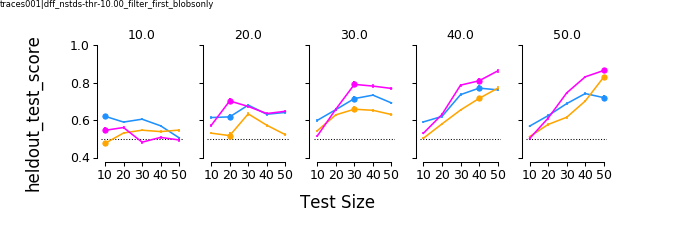

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1', 'train-1_sample-112_iter-100_overlap-0.80_heldout_test_score_split-train-test-transform')


In [480]:
# Plot.

metric = 'heldout_test_score'

fig, axn = pl.subplots(1, 5, figsize=(9,3), sharey=True, sharex=False)
sizes = sdf['size'].unique()

marker='o'
markersize=5
for ax, (train_transform, traindf) in zip(axn.flat, results.groupby(['train_transform'])):
    
    for visual_area, vdf in traindf.groupby(['visual_area']):

        mean_vals = vdf.groupby(['test_transform']).mean()[metric]
        sem_vals = vdf.groupby(['test_transform']).sem()[metric]
        xv = vdf.groupby(['test_transform']).mean().index.values

        ax.errorbar(xv, mean_vals, yerr=sem_vals, color=area_colors[visual_area])
        train_ix = list(sizes).index(train_transform)
        
        ax.errorbar(xv[train_ix], mean_vals.loc[train_transform], yerr=sem_vals.loc[train_transform],
                 marker=marker,markersize=markersize, color=area_colors[visual_area])
        
        ax.set_xticks(xv)
        ax.set_xticklabels([int(s) for s in xv])
    
        ax.set_title(train_transform)
        
    if metric =='heldout_test_score':
        ax.set_ylim([0.4, 1])
        ax.axhline(y=0.5, linestyle=':', color='k', lw=1)
    
fig.text(0.5, 0.1, 'Test Size', ha="center", va="center", fontsize=16)
fig.text(0.05,0.5, metric, ha="center", va="center", rotation=90, fontsize=16)
pl.subplots_adjust(left=0.15, right=0.9, top=0.8, bottom=0.3, wspace=0.3)
sns.despine(trim=True, offset=4)

putils.label_figure(fig, data_id)

figname = '%s_%s_split-train-test-transform' % (plot_str, metric)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


In [481]:
print(metric)

heldout_test_score


In [87]:
test_minus_train=True
sizes = sdf['size'].unique()

metric = 'heldout_test_score'
r_list = []
for visual_area, vdf in results.groupby(['visual_area']):
    for train_transform, traindf in vdf.groupby(['train_transform']):
        t_sizes = [t for t in sizes if t!=train_transform]
        
        curr_train_vals = traindf[traindf['test_transform']==train_transform][metric].values
        curr_iters = traindf[traindf['test_transform']==train_transform]['iteration'].values
        for test_transform in sizes:
            curr_test_vals = traindf[traindf['test_transform']==test_transform][metric].values
            #rel_scores = (curr_train_vals - curr_test_vals) #* curr_train_vals
            if test_minus_train:
                rel_scores = (curr_test_vals - curr_train_vals) #* curr_train_vals
            else:
                rel_scores = (curr_train_vals - curr_test_vals) #* curr_train_vals
            reldf = pd.DataFrame({metric: rel_scores,
                                  'iteration': curr_iters})
            
            add_info = {'visual_area': visual_area, 'train_transform': train_transform, 
                        'test_transform': test_transform}
            reldf = putils.add_meta_to_df(reldf, add_info)
            r_list.append(reldf)
reldf = pd.concat(r_list, axis=0).reset_index(drop=True) 

<IPython.core.display.Javascript object>


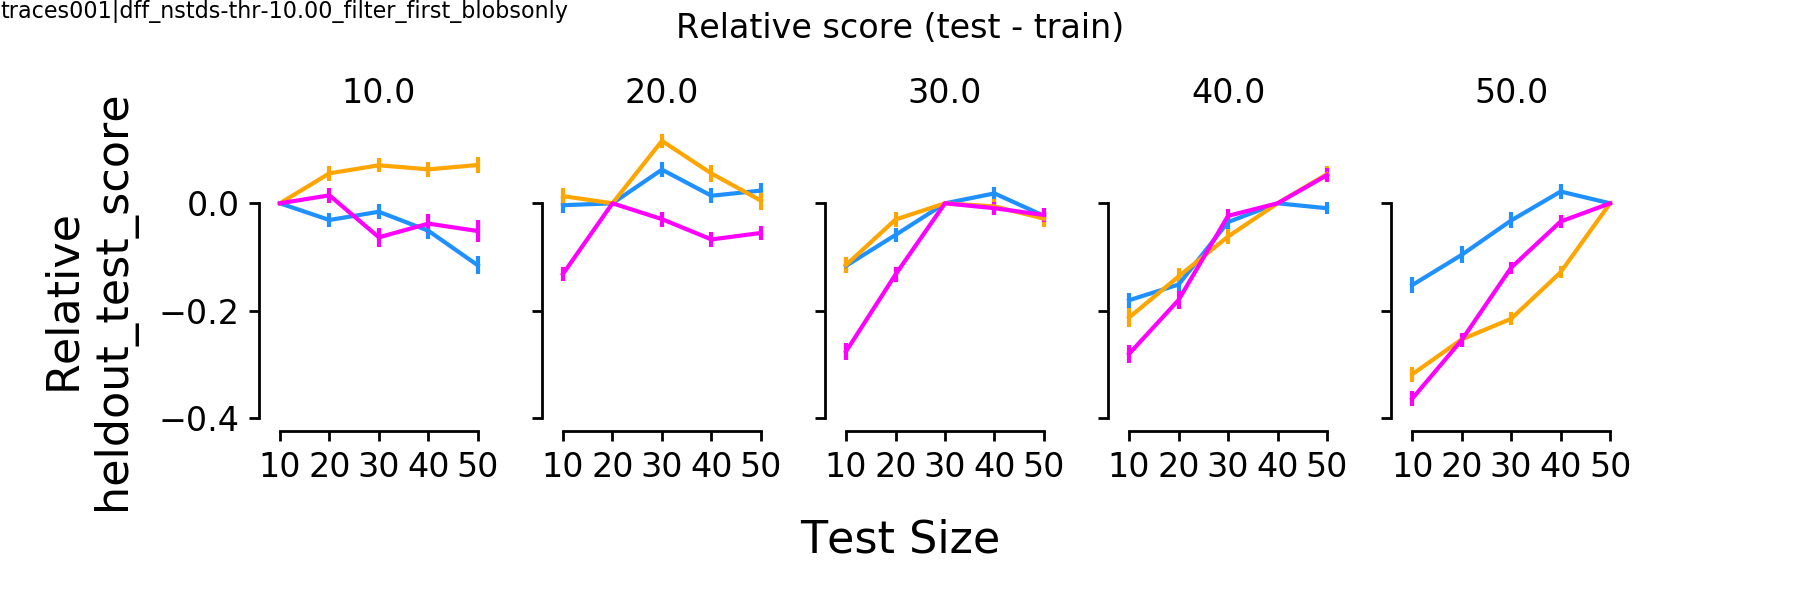

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1', 'train-1_sample-112_iter-100_overlap-0.80_heldout_test_score_split-train-test-transform_RELATIVE-subtract-train')


In [89]:
fig, axn = pl.subplots(1, 5, figsize=(9,3), sharey=True, sharex=False)

for ax, (train_transform, traindf) in zip(axn.flat, reldf.groupby(['train_transform'])):
    
    for visual_area, vdf in traindf.groupby(['visual_area']):

#         mean_vals = vdf[vdf['test_transform']!=train_transform].groupby(['test_transform']).mean()[metric]
#         sem_vals = vdf[vdf['test_transform']!=train_transform].groupby(['test_transform']).sem()[metric]
#         xv = vdf[vdf['test_transform']!=train_transform].groupby(['test_transform']).mean().index.values
        mean_vals = vdf.groupby(['test_transform']).mean()[metric]
        sem_vals = vdf.groupby(['test_transform']).sem()[metric]
        xv = vdf.groupby(['test_transform']).mean().index.values

        ax.errorbar(xv, mean_vals, yerr=sem_vals, color=area_colors[visual_area])

        #ax.axhline(y=0.5, color='k', linestyle=':')
        #ax.set_ylim([0.4, 1])
        ax.set_xticks(xv)
        ax.set_xticklabels([int(s) for s in xv])
    
        ax.set_title(train_transform)
fig.text(0.5, 0.1, 'Test Size', ha="center", va="center", fontsize=16)
fig.text(0.05,0.5, 'Relative\n%s' % metric, ha="center", va="center", rotation=90, fontsize=16)
pl.subplots_adjust(left=0.15, right=0.9, top=0.8, bottom=0.3, wspace=0.3)
sns.despine(trim=True, offset=4)
putils.label_figure(fig, data_id)

if test_minus_train:
    fig.suptitle('Relative score (test - train)')
else:
    fig.suptitle('Relative score (train - test)')

relative_calc = 'subtract-train' if test_minus_train else 'subtract-test'

figname = '%s_%s_split-train-test-transform_RELATIVE-%s' % (plot_str, metric, relative_calc)
#pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [371]:
train_str

'train-1_sample-112_iter-100'

In [372]:
plot_str

'train-1_sample-112_iter-100_overlap-0.80'

In [373]:
fig_str

'dff_nstds-thr-10.00_filter_first_blobsonly'

# Morphs

In [8]:
n_iterations = 100
sample_ncells=112
train_str = 'train-anchors-split-size_sample-%i_iter-%i' % (sample_ncells, n_iterations)  

overlap_thr=0.8
glob.glob(os.path.join(decoding_dir, 'train-anchors', '%s*.pkl' % (train_str)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors/train-anchors-split-size_sample-112_iter-100_results_1.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors/train-anchors-split-size_sample-112_iter-100_results2.pkl']

In [9]:
dst_dir = os.path.join(decoding_dir, 'train-anchors')
results_dfile = glob.glob(os.path.join(dst_dir, '%s*.pkl' % (train_str)))[1]
with open(results_dfile, 'rb') as f:
    results = pkl.load(f)

results_basename = os.path.splitext(os.path.split(results_dfile)[-1])[0]
print("File basename: %s" % results_basename)

File basename: train-anchors-split-size_sample-112_iter-100_results2


In [10]:
plot_str = '%s_overlap-%.2f' % (train_str, overlap_thr)
fig_str = '%s_%s' % (response_str, filter_str)
data_id = '%s|%s' % (traceid, fig_str)
print(data_id)

traces001|dff_nstds-thr-10.00_filter_first_blobsonly


<IPython.core.display.Javascript object>


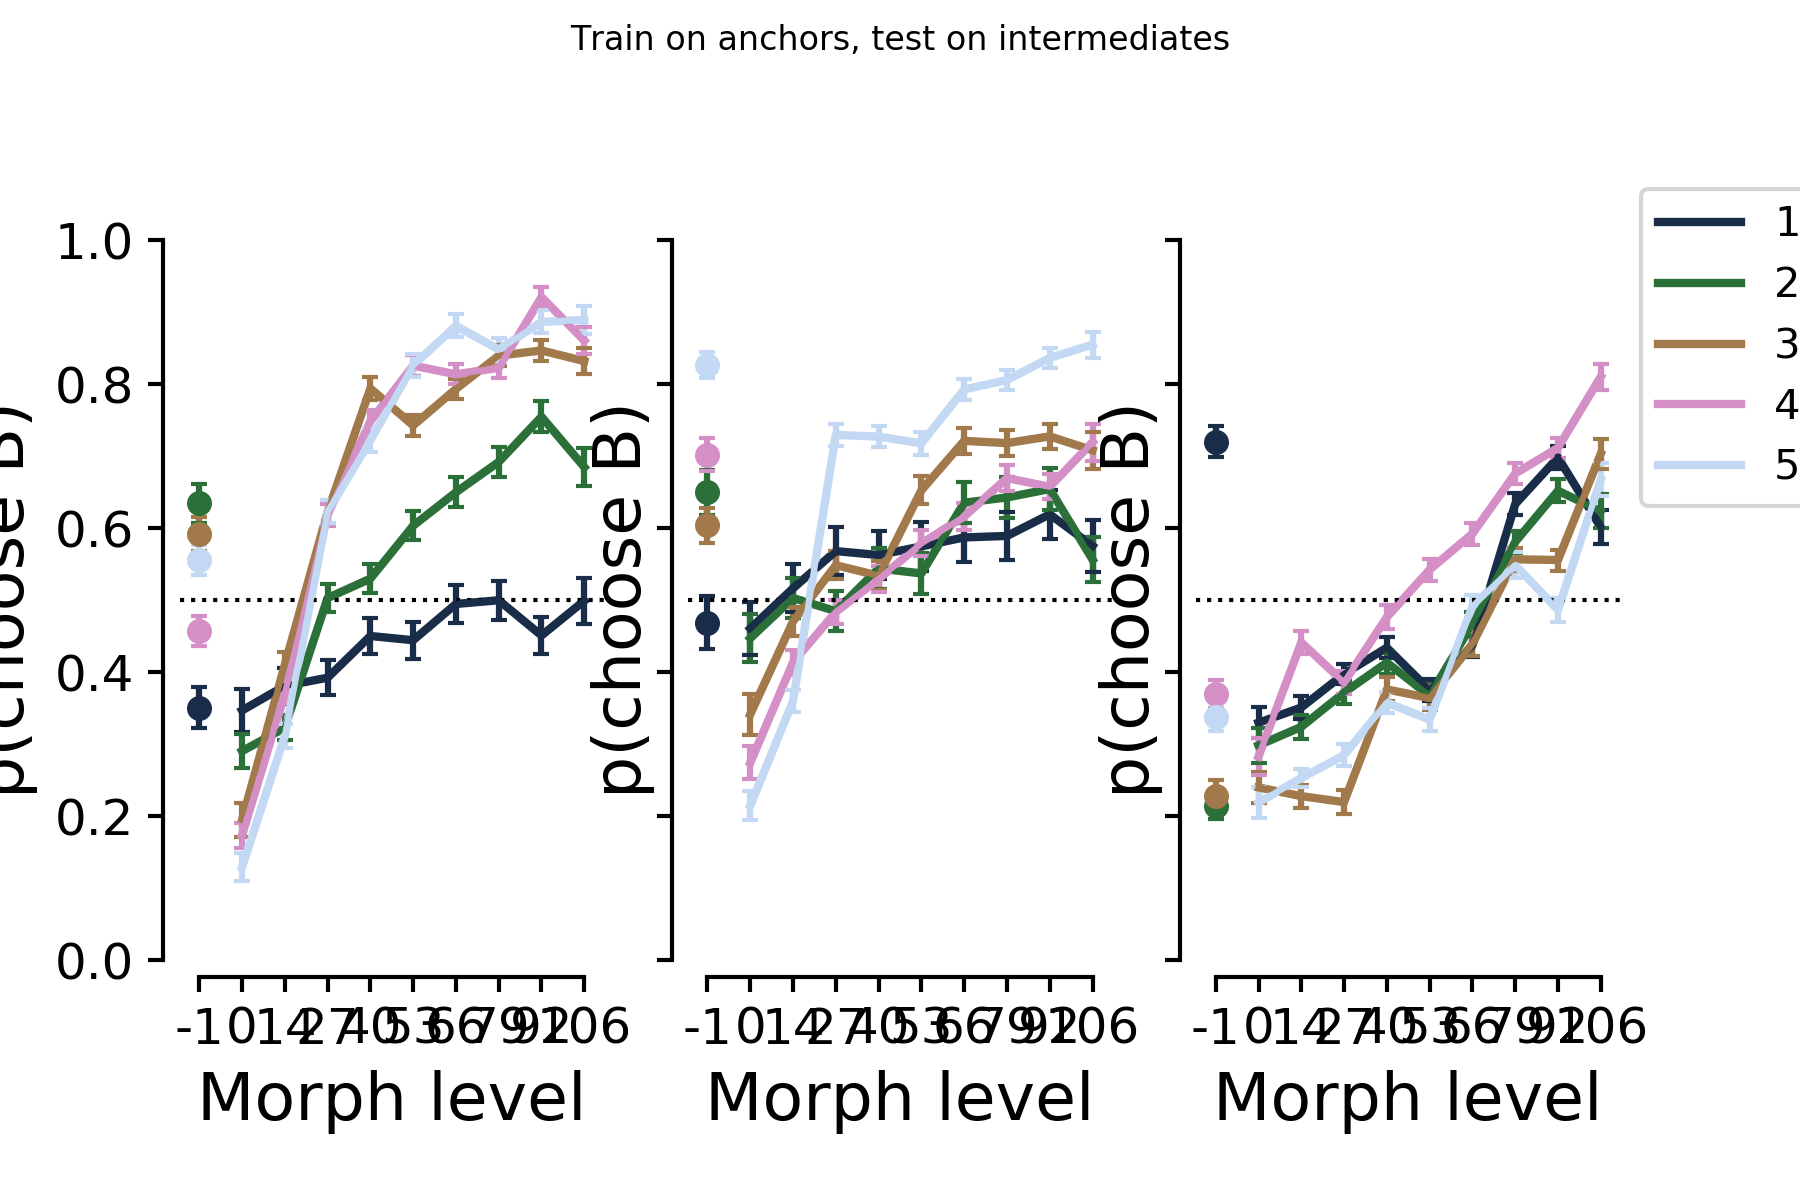

Text(0.5,0.98,u'Train on anchors, test on intermediates')

In [32]:
hue_size = True
col_name = 'morphlevel'
markersize=5
capsize=2
lw=2
alpha = 1

fig, axn = pl.subplots(1, 3, figsize=(6,4), sharex=True, sharey=True, dpi=150)
alphas = np.linspace(0.1, 1, 5)
ci = 95
shade=False
plot_ci=False
plot_luminance= True

plot_str = 'wLum' if plot_luminance else ''
plot_str = '%s_ci%i' % (plot_str, ci) if plot_ci else plot_str

for visual_area, vdf in results.groupby(['visual_area']):
    ai = visual_areas.index(visual_area)
    ax = axn[ai]
    size_colors = sns.color_palette('cubehelix', n_colors=5)
    
    for si, (sz, df_) in enumerate(vdf.groupby(['size'])):
        morphlevels = sorted([s for s in sdf['morphlevel'].unique() if s!=-1])
        xvs = np.arange(1, len(morphlevels)+1) #if plot_luminance else np.arange(0, len(morphlevels))
        
        curr_color = size_colors[si] if hue_size else area_colors[visual_area]
        
        if plot_luminance:
            # plot luminance control
            control_val=-1
            if plot_ci:
                ctl, ctl_lo, ctl_hi = calculate_ci(df_[df_[col_name]==control_val]['p_chooseB'].values, ci=ci)
                yerr = [abs(np.array([ctl-ctl_lo])), abs(np.array([ctl_hi-ctl]))]
            else:
                ctl = df_[df_[col_name]==control_val]['p_chooseB'].mean()
                yerr = df_[df_[col_name]==control_val]['p_chooseB'].sem()

            ax.errorbar(0, ctl, yerr=yerr, color=curr_color,
                           marker='o', markersize=markersize, capsize=capsize, alpha=alpha)
            
        # plot morph curves
        if plot_ci:
            ci_vals = dict((val, calculate_ci(g['p_chooseB'].values, ci=ci)) \
                             for val, g in df_[df_[col_name].isin(morphlevels)].groupby([col_name]))
            mean_vals = np.array([ci_vals[k][0] for k in morphlevels])
            lowers = np.array([ci_vals[k][1] for k in morphlevels])
            uppers =  np.array([ci_vals[k][2] for k in morphlevels])
            yerr = [np.array([mean_vals - lowers]), np.array([mean_vals-uppers])]
        else:
            mean_vals = df_[df_[col_name].isin(morphlevels)].groupby([col_name]).mean()['p_chooseB']
            yerr = df_[df_[col_name].isin(morphlevels)].groupby([col_name]).sem()['p_chooseB']

        ax.plot(xvs, mean_vals, color=curr_color, lw=lw, alpha=alpha, label=sz)
        ax.errorbar(xvs, mean_vals, yerr=yerr, color=curr_color,
                          capsize=capsize, alpha=alpha, label=None)
        ax.set_ylim([0, 1])

    xticks = np.arange(0, len(morphlevels)+1) if plot_luminance else xvs
    xlabels = sdf['morphlevel'].unique() if plot_luminance \
                    else sdf[sdf['morphlevel']!=-1]['morphlevel'].unique()
    ax.set_xticks(xticks)
    ax.set_xticklabels( [int(m) for m in sorted(xlabels)] )
    ax.set_ylabel('p(choose B)')
    ax.set_xlabel('Morph level')
    
    
    ax.axhline(y=0.5, linestyle=':', color='k', lw=1)

    if ai==2:
        ax.legend(bbox_to_anchor=(1, 1.1))                               

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
sns.despine(trim=True, offset=4)
pl.suptitle("Train on anchors, test on intermediates", fontsize=8)


In [35]:
reload(dutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.py'>

<IPython.core.display.Javascript object>


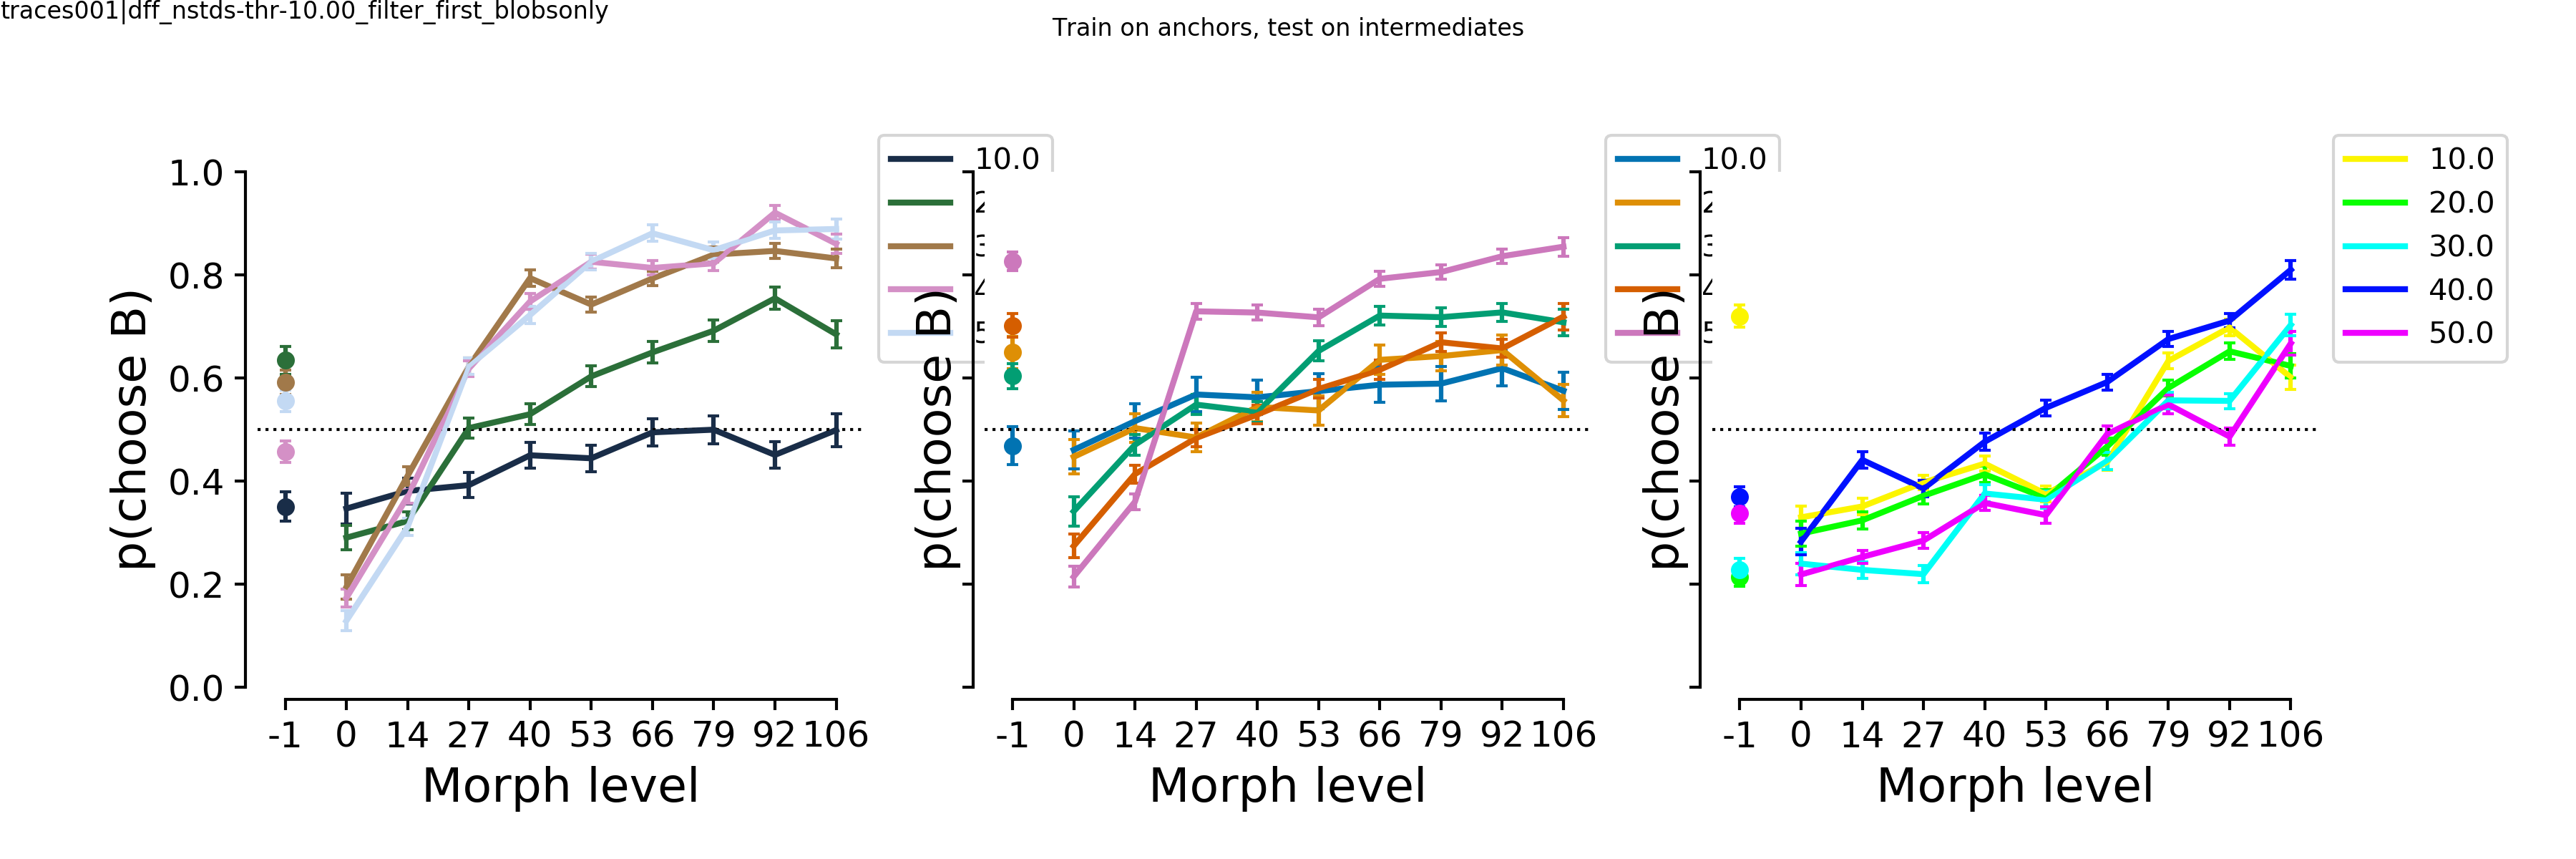

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors', 'train-anchors-split-size_sample-112_iter-100_morphcurves_split-size__wLum')


In [36]:
dutils.default_morphcurves_split_size(results, sdf, area_colors=area_colors, dst_dir=dst_dir, data_id=data_id,
                                    lw=lw, train_str=train_str, capsize=2, hue_size=True)